In [2]:
import os
import re
import abc
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import termcolor
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')

from vision_models import lrs, vit_model_names
from metacognitive_pipeline import fine_grain_classes, n_classes

class Context(abc.ABC):
    @abc.abstractmethod
    def __enter__(self):
        pass

    @abc.abstractmethod
    def __exit__(self, exc_type, exc_val, exc_tb):
        pass
    
class Plot(Context):
    def __init__(self,
                 fig_sizes: tuple = None):
        if fig_sizes:
            plt.figure(figsize=fig_sizes)

    def __enter__(self):
        plt.cla()
        plt.clf()

    def __exit__(self, exc_type, exc_val, exc_tb):
        plt.show()
        plt.cla()
        plt.clf()
        
data_dir = 'results/'  # Set the directory where your .npy files are located

# Initialize dictionaries to store training and test accuracy data for each model
model_train_data = {}
model_test_data = {}

test_true = np.load(os.path.join(data_dir, 'test_true.npy'))

# Loop through all files in the directory
for filename in os.listdir(data_dir):
    train_match = re.match(pattern=r'(.+?)_train_(loss|acc)_lr(.+?)_e(\d+?).npy',
                           string=filename)
    test_match = re.match(pattern=r'(.+?)_test_pred_lr(.+?)_e(\d+?).npy',
                          string=filename)

    if train_match:
        model_name = train_match.group(1)
        metric = train_match.group(2)
        lr_value = float(train_match.group(3))
        num_epochs = int(train_match.group(4)) + 1

        # Load the data from the .npy file
        data = np.load(os.path.join(data_dir, filename))

        # Store the data in the model_data dictionary
        if model_name not in model_train_data:
            model_train_data[model_name] = {}
        if metric not in model_train_data[model_name]:
            model_train_data[model_name][metric] = {}
        if lr_value not in model_train_data[model_name][metric]:
            model_train_data[model_name][metric][lr_value] = {}

        model_train_data[model_name][metric][lr_value][num_epochs] = data[-1]
    elif test_match:
        model_name = test_match.group(1)
        lr_value = float(test_match.group(2))
        num_epochs = int(test_match.group(3)) + 1

        # Load the test data from the .npy file
        test_pred = np.load(os.path.join(data_dir, filename))

        # Store the data in the model_test_data dictionary
        if model_name not in model_test_data:
            model_test_data[model_name] = {}
        if lr_value not in model_test_data[model_name]:
            model_test_data[model_name][lr_value] = {}

        model_test_data[model_name][lr_value][num_epochs] = \
            {'acc': accuracy_score(test_true, test_pred), 
             'cm': confusion_matrix(test_true, test_pred),
             'pre': precision_score(test_true, test_pred, labels=range(n_classes), average=None),
             'rec': recall_score(test_true, test_pred, labels=range(n_classes), average=None),
             'f1': f1_score(test_true, test_pred, labels=range(n_classes), average=None)}

# Train metrics

In [31]:
def plot_train_metrics():
    # Create plots for training metric vs. epoch for each model
    for model_name, model_data in sorted(model_train_data.items()):
        print('\n' + '#'* (100 + len(model_name)))
        print('#'* 50 + f'{model_name}' + '#'* 50)
        print('#'* (100 + len(model_name)) + '\n')
        for metric, metric_data in model_data.items():
            with Plot():
                plt.title(f"{model_name} training {metric} vs. epoch")
                plt.xlabel('Epoch')
                plt.ylabel(metric.capitalize())
    
                for lr_value, lr_data in sorted(metric_data.items()):
                    epochs, data = zip(*sorted(lr_data.items())) # Sort the data based on the number of epochs
                    plt.plot(epochs, data, label=f'lr={lr_value}')
                    plt.xticks(np.arange(min(epochs), max(epochs)+1, 1)) # Set the x-axis ticks to be integers
    
                plt.legend()
                plt.grid()

# plot_train_metrics()

# Test metrics

In [32]:
def plot_test_metrics():
    # Create a dictionary to store accuracy values for each model and learning rate
    accuracy_data = {}

    # Now, create plots for test accuracy vs. epoch for each model
    for model_name, model_data in sorted(model_test_data.items()):
        for lr_value, lr_data in sorted(model_data.items()):
            # Collect the accuracy after the last epoch
            last_epoch = sorted(lr_data.items())[-1][1]
            accuracy = last_epoch['acc']

            # Store the accuracy in the dictionary
            if model_name not in accuracy_data:
                accuracy_data[model_name] = {}
            accuracy_data[model_name][f'lr={lr_value}'] = accuracy


    # Get a list of all learning rates in the data
    all_learning_rates = sorted(set(lr for model_data in accuracy_data.values() for lr in model_data))

    # Generate the 2-D table with manual headers
    headers = ["Model Name"] + all_learning_rates
    table = []

    for model_name in accuracy_data:
        row = [model_name] + [accuracy_data[model_name].get(lr, "N/A") for lr in all_learning_rates]
        table.append(row)

    # Print the table using tabulate
    print(tabulate(table, headers=headers, tablefmt="fancy_grid"))

plot_test_metrics()

╒══════════════╤════════════╤════════════╤════════════╕
│ Model Name   │   lr=1e-05 │   lr=1e-06 │   lr=5e-05 │
╞══════════════╪════════════╪════════════╪════════════╡
│ vit_b_16     │   0.639112 │   0.699568 │   0.645281 │
├──────────────┼────────────┼────────────┼────────────┤
│ vit_b_32     │   0.558914 │   0.636644 │   0.537323 │
├──────────────┼────────────┼────────────┼────────────┤
│ vit_l_16     │   0.699568 │   0.702653 │   0.661937 │
├──────────────┼────────────┼────────────┼────────────┤
│ vit_l_32     │   0.582357 │   0.673041 │   0.624306 │
╘══════════════╧════════════╧════════════╧════════════╛


In [33]:
def plot_verbose_test_metrics(cms: bool = False, 
                              class_wise_accuracies: bool = False):
    # Now, create plots for test accuracy vs. epoch for each model
    for model_name, model_data in sorted(model_test_data.items()):
        print('\n' + '#'* (100 + len(model_name)))
        print('#'* 50 + f'{model_name}' + '#'* 50)
        print('#'* (100 + len(model_name)) + '\n')
        metric = 'Accuracy'
        
        with Plot():
            plt.title(f"{model_name} - Test {metric} vs. Epoch")
            plt.xlabel('Epoch')
            plt.ylabel(metric)
    
            for lr_value, lr_data in sorted(model_data.items()):
                # Sort the data based on the number of epochs
                epochs, epoch_data = zip(*sorted(lr_data.items()))
                plt.plot(epochs, [curr_data['acc'] for curr_data in epoch_data], label=f'lr={lr_value}')
                plt.xticks(np.arange(min(epochs), max(epochs)+1, 1)) # Set the x-axis ticks to be integers
    
            plt.legend()
            plt.grid()
        
        if cms or class_wise_accuracies:
            for lr_value, lr_data in sorted(model_data.items()):
                epochs, epoch_data = zip(*sorted(lr_data.items()))
                
                if cms:
                    with Plot():
                        plt.figure(figsize=(12, 9))
                        sns.heatmap(epoch_data[-1]['cm'], 
                                    annot=True, 
                                    fmt="d",  
                                    xticklabels=fine_grain_classes, 
                                    yticklabels=fine_grain_classes
                                    )
        
                        plt.xlabel('Predicted')
                        plt.ylabel('Actual')
                        plt.title(f'{model_name}, lr={lr_value} Confusion Matrix')
                
                if class_wise_accuracies:
                    for class_label, class_name in enumerate(fine_grain_classes):
                        precision = epoch_data[-1]['pre'][class_label]
                        print(f'{model_name}, lr={lr_value}, {class_name}: Precision = {precision:.2f}')

            
# plot_verbose_test_metrics()

# EDCR Results

In [34]:
models_and_lrs_folders = os.listdir(f'figs')
assert (len(vit_model_names) - 1) * (len(vit_model_names) - 2) * len(lrs) ** 2  == len(models_and_lrs_folders) - 1

len(models_and_lrs_folders) - 1

108

In [35]:
def print_EDCR_results():
    for filename in models_and_lrs_folders:
        match = re.match(pattern=rf'main_(.+?)_lr(.+?)_secondary_(.+?)_lr(.+)',
                         string=filename)
        if match:
            main_model_name, main_lr, secondary_model_name, secondary_lr = (match.group(i) for i in range(1,5))
            prior_predictions = np.load(os.path.join(data_dir, 
                                                     rf'{main_model_name}_test_pred_lr{main_lr}_e3.npy'))
            prior_acc = accuracy_score(y_true=test_true, 
                                       y_pred=prior_predictions)
            
            post_predictions = np.load(f'{data_dir}/figs/{match.group(0)}/results.npy')
            posterior_acc = accuracy_score(y_true=test_true, 
                                           y_pred=post_predictions)
            print('#' * 100 + f'Main: {main_model_name} with lr {main_lr}, '
                              f'secondary: {secondary_model_name} with lr {secondary_lr}\n'
                  f'Prior acc:{prior_acc}, post acc: {posterior_acc}\n')
            print(termcolor.colored(f"Total acc change {'+' if posterior_acc > prior_acc else ''}"
                                    f"{round((posterior_acc - prior_acc)*100, 3)}%", 
                                    'green' if posterior_acc > prior_acc else 'red'))

# print_EDCR_results()

In [84]:
# Sample data structure (replace this with your actual data)
data = {}  # Create an empty dictionary to store the accuracy data

# Track the maximal accuracy value across all tables
max_accuracy = -1.0
max_data = {}

# Iterate through filenames to collect accuracy data
for filename in models_and_lrs_folders:
    match = re.match(pattern=rf'main_(.+?)_lr(.+?)_secondary_(.+?)_lr(.+)', 
                     string=filename)
    if match:
        main_model_name, main_lr, secondary_model_name, secondary_lr = (match.group(i) for i in range(1, 5))
        prior_predictions = np.load(os.path.join(data_dir, rf'{main_model_name}_test_pred_lr{main_lr}_e3.npy'))
        prior_acc = accuracy_score(y_true=test_true, 
                                   y_pred=prior_predictions)

        post_predictions = np.load(f'figs/{match.group(0)}/results.npy')
        posterior_acc = accuracy_score(y_true=test_true, 
                                       y_pred=post_predictions)

        # Update the maximal accuracy value
        if posterior_acc > max_accuracy:
            max_accuracy = posterior_acc
            max_data = {'main_model_name': main_model_name,
                        'main_lr': main_lr,
                        'secondary_model_name': secondary_model_name,
                        'secondary_lr': secondary_lr}

        # Store accuracy data in the data dictionary
        if main_model_name not in data:
            data[main_model_name] = {}
        if main_lr not in data[main_model_name]:
            data[main_model_name][main_lr] = {}
        if secondary_model_name not in data[main_model_name][main_lr]:
            data[main_model_name][main_lr][secondary_model_name] = {}
            
        data[main_model_name][main_lr][secondary_model_name][secondary_lr] = {'prior': prior_acc, 
                                                                              'post': posterior_acc}

# Loop through each main model and generate a table
for main_model_name, main_lr_data in data.items():
    table_data = []

    # Get a list of learning rates from the first secondary model
    main_learning_rates = sorted(main_lr_data.keys())
    
    secondary_models_data = list(main_lr_data.values())
    # Sort the secondary model names
    sorted_secondary_models = sorted(secondary_models_data[0].keys())

    # Create the header row with learning rates
    header = [''] + main_learning_rates
    table_data.append(header)

    # Add rows for each secondary model, ensuring they are sorted
    for secondary_model_name in sorted_secondary_models:
        curr = {secondary_model_name: v[secondary_model_name] for v in main_lr_data.values()}
        accuracy_data = curr[secondary_model_name]
        row = [secondary_model_name] + ['\n'.join([f"{secondary_lr}: {round(data[main_model_name][main_lr][secondary_model_name][secondary_lr]['post']*100, 2)}% "
                                    f"({round(data[main_model_name][main_lr][secondary_model_name][secondary_lr]['prior']*100, 2)}%, "
                                    + termcolor.colored(f"{'+' if data[main_model_name][main_lr][secondary_model_name][secondary_lr]['post'] > data[main_model_name][main_lr][secondary_model_name][secondary_lr]['prior'] else ''}", color='green') +
                                    termcolor.colored(f"{round((data[main_model_name][main_lr][secondary_model_name][secondary_lr]['post'] - data[main_model_name][main_lr][secondary_model_name][secondary_lr]['prior'])*100, 2)}%)", color='green' if data[main_model_name][main_lr][secondary_model_name][secondary_lr]['post'] > data[main_model_name][main_lr][secondary_model_name][secondary_lr]['prior'] else 'red')
                                    + '\n' for secondary_lr in main_learning_rates])
                                   for main_lr in main_learning_rates]
        table_data.append(row)

    # Find the maximal accuracy value and its position in the table
    max_acc_value = max(max([element.split()[0] for element in row[1:]] for row in table_data[1:]))
    # max_acc_row, max_acc_col = [(i, row.index(max_acc_value)) 
    #                             for i, row in enumerate(table_data) if max_acc_value in row][0]
    # 
    # # Colorize the maximal accuracy cell in green
    # table_data[max_acc_row][max_acc_col] = termcolor.colored(text=max_acc_value, 
    #                                                          color='green')

    # Create the table using tabulate
    table = tabulate(tabular_data=table_data, 
                     headers='firstrow', 
                     tablefmt='grid')

    # Print the main model name and the corresponding table
    print(f"Main Model: {main_model_name}")
    print(table)
    print("\n")

# Print the maximal accuracy value across all tables (already colored in green)
print(f"Overall maximal post accuracy {round(max_accuracy*100, 2)}%")
print(max_data)

Main Model: vit_l_16
+------+--------------------------------+--------------------------------+--------------------------------+
|      | 1e-05                          | 1e-06                          | 5e-05                          |
+======+================================+================================+================================+
| b_16 | 1e-05: 69.52% (69.96%, -0.43%) | 1e-05: 69.28% (70.27%, -0.99%) | 1e-05: 66.26% (66.19%, +0.06%) |
|      |                                |                                |                                |
|      | 1e-06: 70.7% (69.96%, +0.74%)  | 1e-06: 71.75% (70.27%, +1.48%) | 1e-06: 68.04% (66.19%, +1.85%) |
|      |                                |                                |                                |
|      | 5e-05: 70.27% (69.96%, +0.31%) | 5e-05: 70.82% (70.27%, +0.56%) | 5e-05: 67.18% (66.19%, +0.99%) |
+------+--------------------------------+--------------------------------+--------------------------------+
| b_32 


############################################################################################################
##################################################vit_b_16##################################################
############################################################################################################


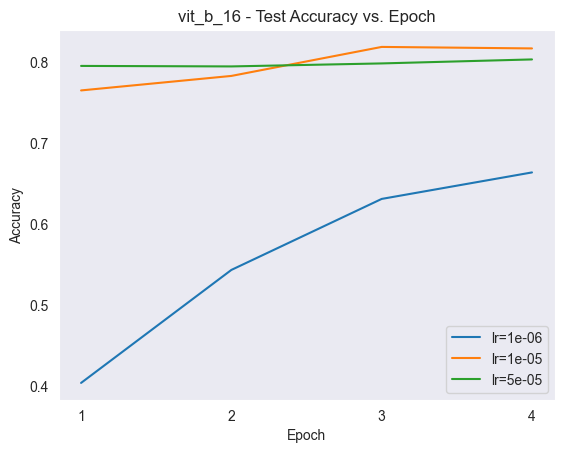


############################################################################################################
##################################################vit_b_32##################################################
############################################################################################################


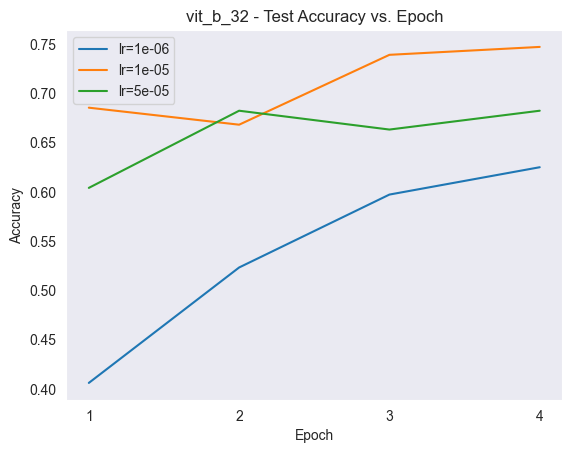

<Figure size 640x480 with 0 Axes>